<h1 align=center><font size = 5>Stock Prediction using LSTMs through PyTorch and yFinance</font></h1>

## Overview

In this notebook, we will be building a model that uses LTSMs for Stock Value Prediction using PyTorch and pandas built in yFinance library.

LTSMs stand for Long Short-Term Memory, which is a type of recurrent neural network (RNN) architecture. LSTMs are designed to overcome the limitations of traditional RNNs in capturing long-range dependencies in sequential data.

Here's a brief explanation:

### RNNs and the Vanishing Gradient Problem: 
Traditional RNNs have difficulties learning and retaining information from earlier time steps in a sequence, which is known as the vanishing gradient problem. This makes them less effective for tasks involving long-term dependencies.

### LSTM Architecture: 
LSTMs were introduced to address the vanishing gradient problem. They have a more complex architecture compared to traditional RNNs, featuring a memory cell and various gates. The key components include:

#### Memory Cell: 
This is the component that stores information over long periods, and its state can be selectively modified through input, output, and forget gates.

#### Input Gate: 
Determines what information from the current time step should be stored in the memory cell.

#### Forget Gate: 
Decides what information should be discarded from the memory cell.

#### Output Gate: 
Controls the output based on the current input and the memory cell's state.

### Training: 
LSTMs are trained using backpropagation through time (BPTT), a variant of backpropagation suitable for sequences. The architecture of LSTMs allows them to mitigate the vanishing gradient problem and capture dependencies over longer sequences.

### Application: 
As stock data is inherently sequential, the architechture of LTSMs is ideal for this use case

## Imports

In [1]:
# pip install matplotlib
# pip install torch
# pip install torch torchvision
# pip install numpy
# pip install pandas
# pip install yfinance
# pip install plotly

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Set the style and font family for matplotlib
plt.style.use("seaborn-v0_8")
plt.rcParams['font.family'] = 'helvetica'

## Load Data

In [3]:
def download_stock_data(tickers, start_date, end_date):
    data = {}
    for ticker in tickers:
        stock_data = yf.download(ticker, start=start_date, end=end_date, interval=data_interval)
        data[ticker] = stock_data['Adj Close']  # Adjusted close prices
    # Save the data to a CSV file
    pd.DataFrame(data).to_csv(cache_path)
    print(f"Stock data saved to {cache_path}")
    return pd.DataFrame(data)

# Calculate the start date as one year ago from the current date
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=729)).strftime('%Y-%m-%d')

# Define the interval for the data (e.g., '1d' for daily, '1wk' for weekly, '1h' for hourly)
data_interval = '1h'

# Stock Tickers
stock_tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']

# Specify the path where you want to save the CSV file
cache_path = './data.csv'

# Download stock data
stock_dataframe = download_stock_data(stock_tickers, start_date, end_date)

# Display the DataFrame
stock_dataframe.head(5)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Stock data saved to ./data.csv


,AAPL,GOOGL,MSFT,AMZN
Datetime,,,,
2021-11-02 09:30:00-04:00,150.069794,146.400192,331.959991,165.401001
2021-11-02 10:30:00-04:00,151.188004,146.164246,332.200012,164.725006
2021-11-02 11:30:00-04:00,150.990005,145.606003,332.500000,164.794998
2021-11-02 12:30:00-04:00,151.035004,145.145996,332.549988,164.779999
2021-11-02 13:30:00-04:00,150.505005,144.859894,332.760010,164.675751


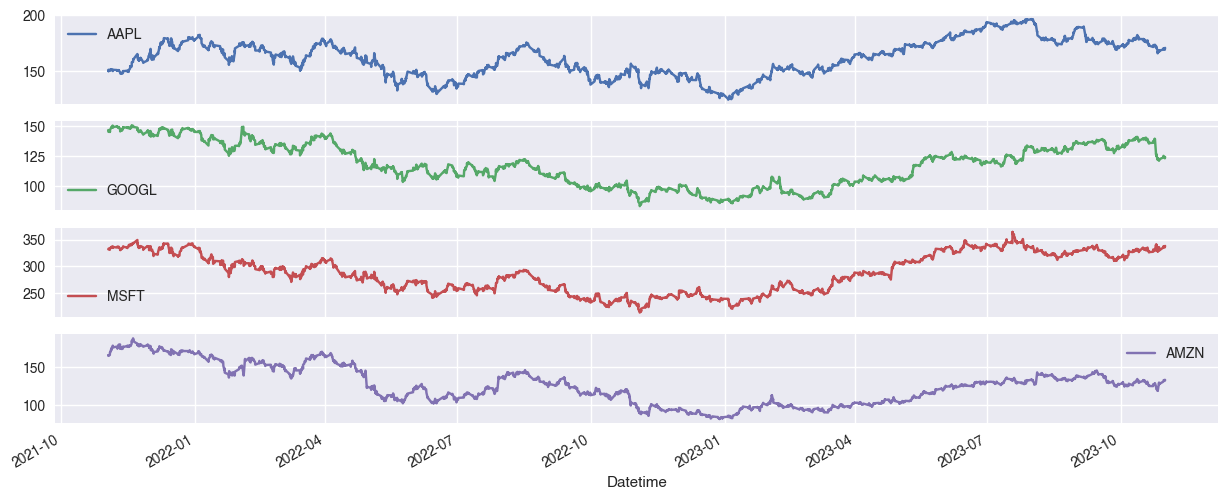

In [4]:
dates = pd.date_range(start_date,end_date)
df = stock_dataframe
df.plot(figsize=(15, 6), subplots=True);

In [5]:
# You can change the ticker to any stock
stock_name = 'AAPL'
stock_data = yf.download(stock_name, start=start_date, end=end_date, interval=data_interval)
stock_data.head(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-11-02 09:30:00-04:00,149.039993,150.309006,148.649994,150.069794,150.069794,18957409
2021-11-02 10:30:00-04:00,150.070007,151.220001,150.069901,151.188004,151.188004,11031133
2021-11-02 11:30:00-04:00,151.171005,151.570007,150.585007,150.990005,150.990005,8867338
2021-11-02 12:30:00-04:00,151.002594,151.479996,150.842697,151.035004,151.035004,6136644
2021-11-02 13:30:00-04:00,151.035004,151.130005,150.440002,150.505005,150.505005,5544538


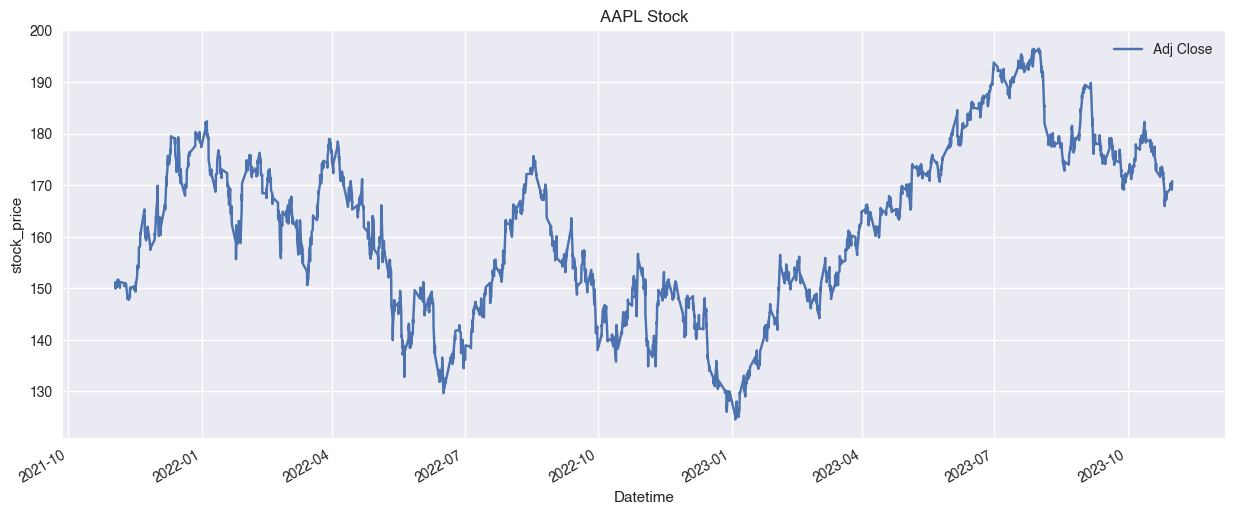

In [6]:
stock_data[['Adj Close']].plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title(stock_name +" Stock")
plt.show()

We only want to operate on the Adj Close column of stock_data, so we will overwrite our variable to be univariate.

In [7]:
stock_data = stock_data[['Adj Close']]
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3502 entries, 2021-11-02 09:30:00-04:00 to 2023-10-31 15:30:00-04:00
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  3502 non-null   float64
dtypes: float64(1)
memory usage: 54.7 KB


In [8]:
stock_data.head()

,Adj Close
Datetime,
2021-11-02 09:30:00-04:00,150.069794
2021-11-02 10:30:00-04:00,151.188004
2021-11-02 11:30:00-04:00,150.990005
2021-11-02 12:30:00-04:00,151.035004
2021-11-02 13:30:00-04:00,150.505005


## Normalizing and Sequencing Data

We now normalize our data between -1 and 1 using a Min-Max scaler. We only want to scale our single 'Adj Close' column. We use df.loc as it is more efficient in pandas.

In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
stock_data.loc[:, 'Adj Close'] = scaler.fit_transform(stock_data['Adj Close'].values.reshape(-1, 1))

We can now create function to load, train, and test data given stock data and sequence length.

In [10]:
def load_data(stock, sequence_length):
    data_raw = stock.values
    data = []
    
    # create all possible sequences of length sequence_length and append to our data array
    for index in range(len(data_raw) - sequence_length): 
        data.append(data_raw[index: index + sequence_length])
    
    # convert into numpy array and set the test and train set sizes
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    # selects the first sequences up to the size of train_set_size
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    # selects the remaining sequences from the size of train_set_size on
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [11]:
sequence_length = 50 # choose sequence length
x_train, y_train, x_test, y_test = load_data(stock_data, sequence_length)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2762, 49, 1)
y_train.shape =  (2762, 1)
x_test.shape =  (690, 49, 1)
y_test.shape =  (690, 1)


In [12]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

## Build the LSTM Model

We are now going to construct the LSTM model class. We need to shape the LSTM with input dimensions, hidden dimensions, and number of recurrent layers. For instance, setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Thus, we initialize hidden_dim and num_layers in the first part of the \__init__. We also need to force our model to output only one predicted value.

In the second part of \__init__, we set out the layers of our network. Our first layer is obviously a recurrent application of LSTM cells, with all the parameters specified above.

Next, we pass this to a fully connected linear layer, which has an input of hidden_size (the size of the output from the last LSTM layer) and outputs 1 activation.

In [13]:
# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_len, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Access the last time step
        out = self.fc(out[:, -1, :]) 

        return out

In [14]:
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(model)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [15]:
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


## Train Model

In [16]:
num_epochs = 100
hist = np.zeros(num_epochs)

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    # Calculate training loss
    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

Epoch  10 MSE:  0.01596050150692463
Epoch  20 MSE:  0.018548959866166115
Epoch  30 MSE:  0.008282008580863476
Epoch  40 MSE:  0.004941737279295921
Epoch  50 MSE:  0.0036857023369520903
Epoch  60 MSE:  0.002899803454056382
Epoch  70 MSE:  0.0025374991819262505
Epoch  80 MSE:  0.002290796721354127
Epoch  90 MSE:  0.0021545831114053726


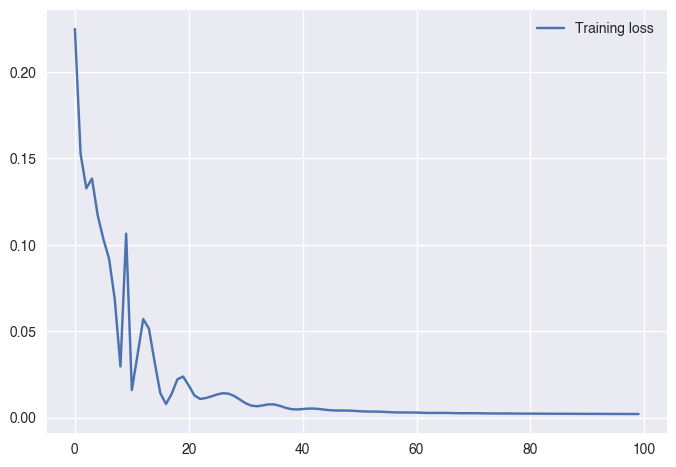

In [17]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

## Make Predictions

In [18]:
# Make predictions
y_test_pred = model(x_test)

# Invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.63 RMSE
Test Score: 1.32 RMSE


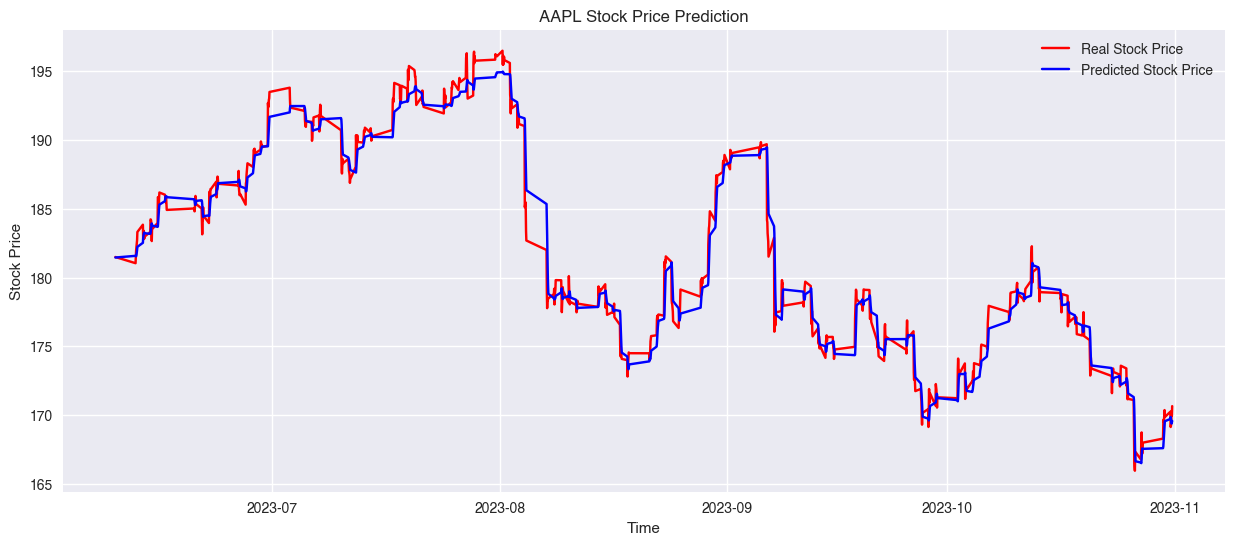

In [29]:
# Visualising the results
fig, axis = plt.subplots(figsize=(15, 6))

axis.plot(stock_data[len(stock_data)-len(y_test):].index, y_test, color = 'red', label = 'Real Stock Price')
axis.plot(stock_data[len(stock_data)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title(stock_name + ' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Although this was a fun experiement, I imagine that univariate LSTMs are not very good at predicting stock prices as they seem to be reliant on last known pricing, likely due to data leakage, rather than making an actual prediction. If we input highly volatile stocks or stocks without much data like NVDA or TSLA on a daily basis, our model underperforms even more. In a system such as the stock market, although there is general longterm uptrend regarding the overall market, the high noise environment makes it difficult for short term trades.